# Transverse field ising models to demo primitives

In [103]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

def generate_1D_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers=False, layer_barriers=False):
    if num_cl_bits == 0:
        qc=QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    for trotter_step in range(num_trotter_steps):
        add_1D_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

    return qc

def add_1D_tfim_trotter_layer(qc, rx_angle, layer_barriers=False):
    #Adding Rzz in even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    
    #Adding Rzz in odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()

    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

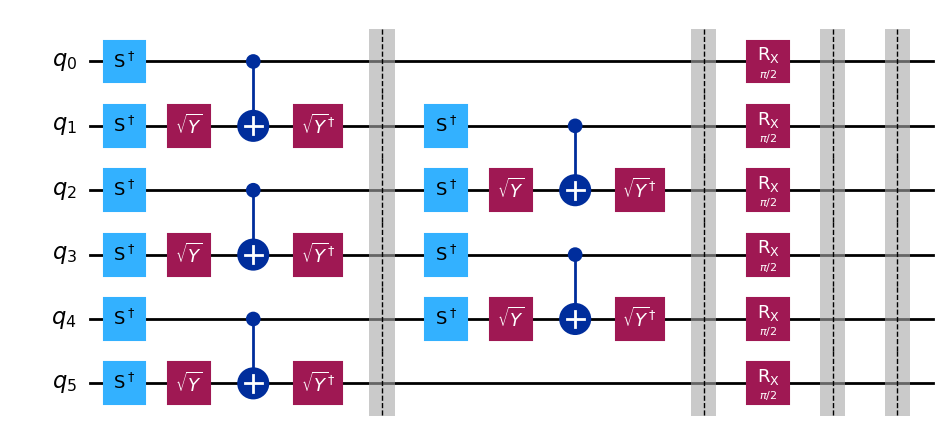

In [183]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5*np.pi

qc=generate_1D_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output="mpl", fold=-1)

# Demo Sampler

In [184]:
def append_mirrored_1D_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=False, layer_barriers=False):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1D_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
            
def add_mirrored_1D_tfim_trotter_layer(qc, rx_angle, layer_barriers=False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    #adding Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()
    #adding Rzz in even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()

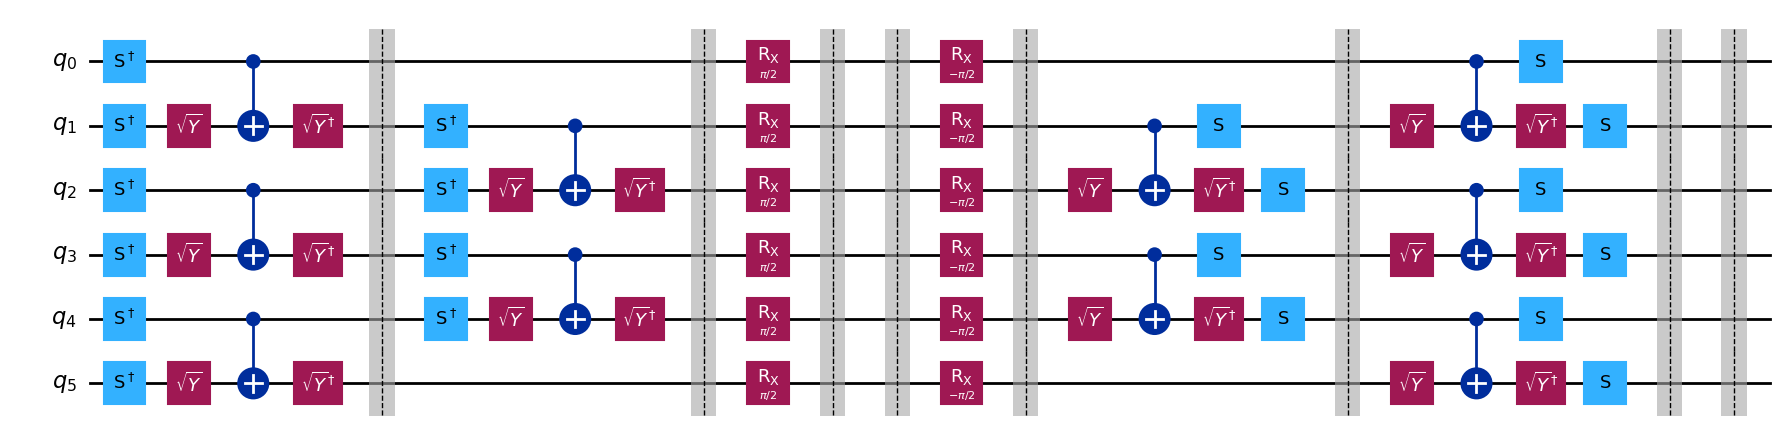

In [185]:
append_mirrored_1D_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output="mpl", fold=-1)

# STep1: Map the problem to circuits and observables

In [107]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list=[]
for trotter_step in range(max_trotter_steps):
    qc = generate_1D_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    append_mirrored_1D_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc) 
    

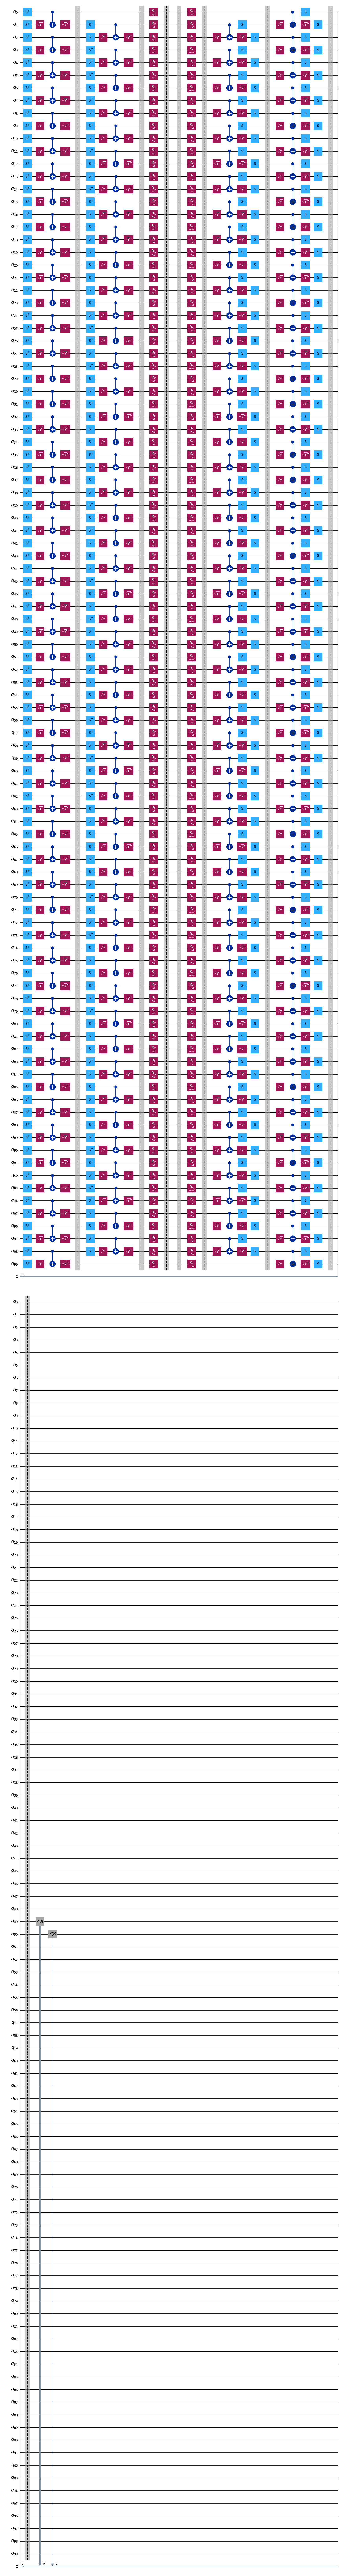

In [108]:
qc_list[1].draw(output="mpl")

# Step 2: Optimize

In [156]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name="ibm_brisbane"
service=QiskitRuntimeService()
backend=service.backend(backend_name)
print("Got your back-end")

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

Got your back-end


# Step 3: Execute on hardware

In [157]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler=Sampler(backend)
sampler.options.dynamical_decoupling.enable=True
sampler.options.dynamical_decoupling.sequence_type="XY4"

job=sampler.run(qc_transpiled_list)
print(job.job_id())


czbanmeb7tt0008gavxg


# Step 4: Post-processing and plotting

In [158]:
job_id = "czbanmeb7tt0008gavxg"
job = service.job(job_id)

survival_probability_list=[]
for trotter_step in range(max_trotter_steps):
    try:
        data=job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0'*len(measured_qubits)]/data.c.num_shots)
    except:
        survival_probability_list.append(0)
print(survival_probability_list)

[0.930419921875, 0.9345703125, 0.935302734375, 0.939697265625, 0.940185546875, 0.930908203125, 0.928955078125, 0.935791015625, 0.93408203125, 0.936767578125]


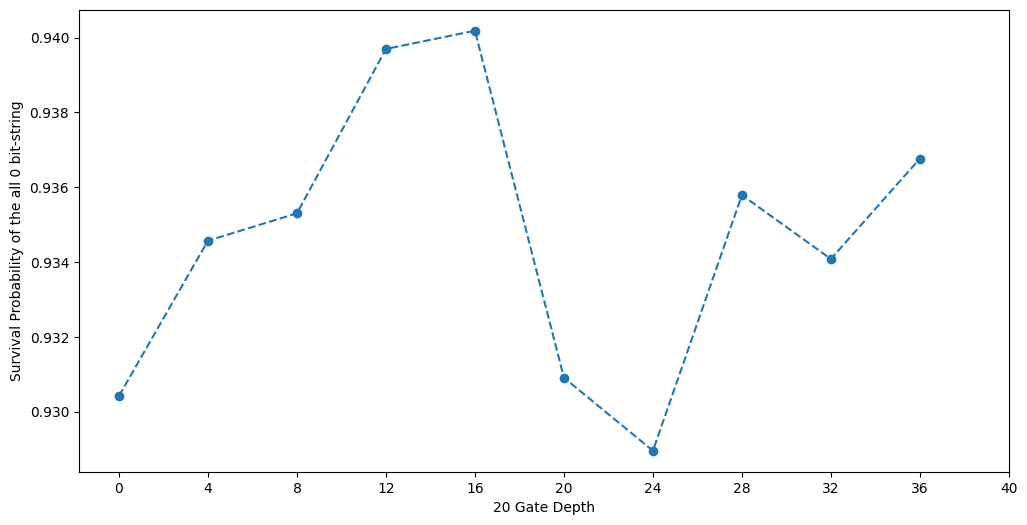

In [168]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(list(range(0,4*max_trotter_steps,4)), survival_probability_list, '--o')

plt.xlabel('20 Gate Depth')
plt.ylabel('Survival Probability of the all 0 bit-string')
#plt.ylim(0,2)
plt.xticks(np.arange(0,44,4))
plt.show()

# Estimator

# STep 1: Mapping the problem

In [169]:
from qiskit.circuit import Parameter
rx_angle = Parameter("rx_angle")
trotter_steps = 2
qc = generate_1D_tfim_circuit(num_qubits, trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits//2
observable = SparsePauliOp("I"*middle_index+"Z"+"I"*(middle_index-1))

# Step 2: Optimize this circuit

In [171]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name="ibm_brisbane"
service=QiskitRuntimeService()
backend=service.backend(backend_name)

qc_traspiled=transpile(qc, backend=backend, optimization_level=1)
observable=observable.apply_layout(qc_traspiled.layout)

# Step 3: Execute

In [178]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle=0
max_rx_angle=np.pi/2
num_rx_angle=12
rx_angle_list=np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options=EstimatorOptions()
options.resilience_level=1
options.dynamical_decoupling.enable=True
options.dynamical_decoupling.sequence_type="XY4"

estimator=EstimatorV2(backend, options=options)

job=estimator.run([(qc_traspiled, observable, rx_angle_list)])
print(job.job_id())

czbj4kjhfwp0008851pg


# Step 4: Post-processing and plotting

(-0.1, 1.1)

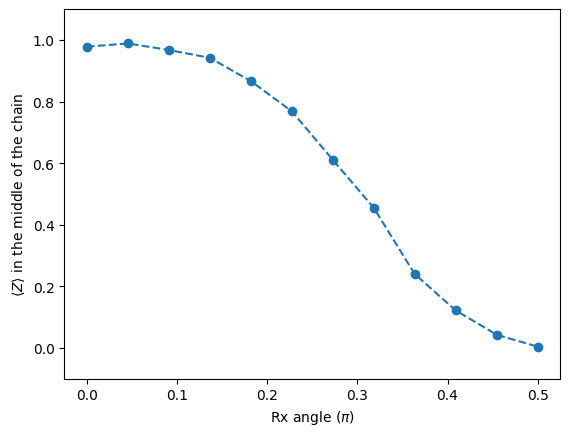

In [181]:
job_id="czbj4kjhfwp0008851pg"
job=service.job(job_id)

exp_val_list=job.result()[0].data.evs

plt.plot(rx_angle_list/np.pi, exp_val_list, "--o")
plt.xlabel(r"Rx angle ($\pi$)")
plt.ylabel(r"$\langle Z \rangle$ in the middle of the chain")
plt.ylim(-0.1,1.1)